# COMP42115: Natural Language Analysis
## Sumative Assesment: Sentiment Analysis Model

In [1]:
# importing the nescessary libraies
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn


%matplotlib inline

from bs4 import BeautifulSoup
import re
import string
from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import hstack

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from scipy.sparse import csr_matrix
import torch

### Data preprocessing

In [2]:
# random seed
seed = 555

In [3]:
# loading the dataset
body = pd.read_csv('data/train_bodies.csv')
stance = pd.read_csv('data/train_stances.csv')

In [4]:
print(stance.shape)
stance.head()

(49972, 3)


,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [5]:
print(body.shape)
body.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [6]:
# merging the dataset
def merge_stance_body(stance, body):
    merged_data = pd.merge(stance, body, on='Body ID')
    return merged_data

df = merge_stance_body(stance, body)

In [7]:
# spliting the data into train, test and validation
train, test = train_test_split(df, test_size=0.30, random_state=seed)
train, val = train_test_split(train, test_size=0.20, random_state=seed)

In [8]:
print(train.shape)
train.head()

(27984, 4)


,Headline,Body ID,Stance,articleBody
23952,Media outlets identify 'Jihadi John',1346,discuss,THE ISLAMIC State murderer dubbed 'Jihadi John...
34151,"Rats at Vogue's NYC offices - watch your step,...",2498,agree,"In case you missed it, Vogue Magazine, one of ..."
33468,US drones hunt Isis leader in Syria,2443,discuss,There have been reports of predator drones bei...
43150,Apple Watch Gold Edition may cost as much as $...,2471,unrelated,Gill Rosenberg is reported to have been captur...
36227,HBO and Apple in Talks for $15/Month Apple TV ...,516,unrelated,A married Russian TV star woke up one day to d...


In [9]:
print(val.shape)
val.head()

(6996, 4)


,Headline,Body ID,Stance,articleBody
16486,US officials: Video shows American's execution,298,unrelated,Although Canadian police have not released the...
33030,Isilkulskom student has gained superhero power...,1503,unrelated,The internet is buzzing this morning with news...
18150,Iraqi social-media rumors claim IS leader slain,1631,unrelated,This is Sergeant-at-Arms Kevin Vickers who rep...
24707,Report: Israeli-Canadian woman fighting Islami...,2002,unrelated,BAGHDAD — Three hundred Iraqi soldiers died in...
2712,Pope Francis turns out not to have made pets i...,1905,disagree,NEW YORK — Pope Francis has given hope to gays...


In [10]:
print(test.shape)
test.head()

(14992, 4)


,Headline,Body ID,Stance,articleBody
38740,Militant Group Says It Killed American Journal...,2261,unrelated,From the midweek edition of the Morning Jolt:\...
13806,"Michael Zehaf-Bibeau, slain Ottawa shooter, ha...",186,unrelated,The sound of 10 or 11 shots from the gun of Fe...
7047,REPORT: Alleged New Audio of Michael Brown Sho...,345,unrelated,"UTAH COUNTY — Over the years, holiday office C..."
14746,Kim Jong-un Broke Both Ankles and Is Hospitali...,859,discuss,Kim Jong-Un had ankle surgery and is now recov...
49782,Report: Amazon to Launch Ad-Supported Streamin...,2442,unrelated,Google leased all 1.9 million square feet of M...


In [12]:
# spliting the data into X, Y
def split(data):
    X = data.drop(['Body ID','Stance'], axis=1)
    Y = data['Stance']
    return X,Y

X_train, Y_train = split(train)
X_val, Y_val = split(val)
X_test, Y_test = split(test)

In [13]:
# cleaning texts
def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.replace('\n','')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    text = remove_stopwords(text)
    return text

In [14]:
def clean_data(data):
    data['Headline'] = [clean_text(i) for i in data['Headline']]
    data['articleBody'] = [clean_text(i) for i in data['articleBody']]
    return data

X_train = clean_data(X_train)
X_val = clean_data(X_val)
X_test = clean_data(X_test)

In [14]:
X_train.head()

,Headline,articleBody
23952,media outlets identify jihadi john,islamic state murderer dubbed jihadi john name...
34151,rats vogues nyc offices watch step anna wintour,case missed vogue magazine glamorous instituti...
33468,drones hunt isis leader syria,reports predator drones launched iraq reports ...
43150,apple watch gold edition cost 5000,gill rosenberg reported captured women fightin...
36227,hbo apple talks 15month apple tv streaming ser...,married russian tv star woke day discover test...


### Task 1 preparation

unrelated    20460
discuss       4993
agree         2057
disagree       474
Name: Stance, dtype: int64

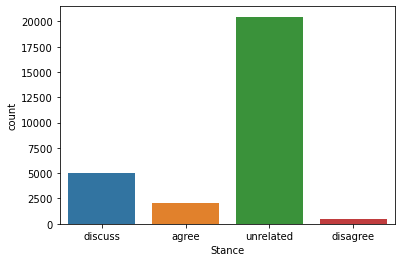

In [15]:
# plotting out the classes
sn.countplot(data=train, x='Stance')
train['Stance'].value_counts()

In [16]:
# replacing agree, disagree, and discuss with related
def get_relation(y):
    related = {'agree': 1,
               'discuss': 1,
               'disagree': 1,
               'unrelated': 0}
    y = y.replace(related)
    return y

Y_train = get_relation(Y_train)
Y_val = get_relation(Y_val)
Y_test = get_relation(Y_test)

0    20460
1     7524
Name: Stance, dtype: int64

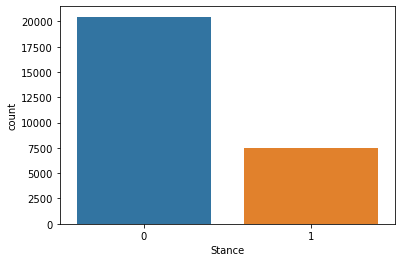

In [17]:
# plotting out the modified classes
sn.countplot(x=Y_train)
Y_train.value_counts()

In [18]:
# using random under samplier to resample the dataset
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=seed)
X_train, Y_train = rus.fit_resample(X_train, Y_train)
temp_df = X_train
temp_df['Stance'] = Y_train
temp_df = temp_df.sample(frac=1, random_state=seed)
X_train = temp_df.drop(['Stance'], axis=1)
Y_train = temp_df['Stance']

0    7524
1    7524
Name: Stance, dtype: int64

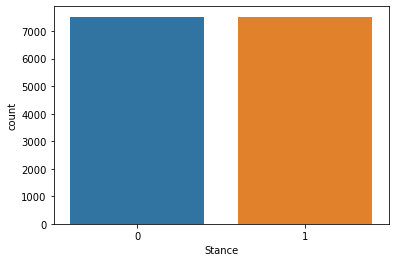

In [19]:
# checking for classes count again
sn.countplot(x=Y_train)
Y_train.value_counts()

### TFIDF vecterisation

In [74]:
# training tfidf vectoriser
tfidf_vec = pd.concat([X_test['articleBody'], X_train['articleBody']])
tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2, max_features=500)
tfidf.fit(tfidf_vec)

TfidfVectorizer(decode_error='ignore', max_features=500, min_df=2)

In [75]:
# selecting random words from tfidf dictionary
dictionary = np.asarray(tfidf.get_feature_names())
print(dictionary[np.random.randint(0,len(dictionary),size=50)])

['state' 'groups' 'woods' 'appears' 'came' 'september' 'arrested' 'staff'
 'known' 'york' 'officer' 'comment' 'children' 'staff' 'claim' 'they'
 'carried' 'wanted' 'amazon' 'wearing' 'blumenthal' 'later' '20'
 'hostages' 'dog' 'kobani' 'woods' 'spoke' 'he' 'caught' 'second'
 'possible' 'called' 'middle' 'white' 'president' 'held' 'youtube'
 'interview' 'love' 'daily' 'media' 'launch' 'took' 'man' 'air'
 'statement' 'francis' 'mosul' 'rumors']


C:\Users\Ice\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [76]:
# transfroming data into vectors by stacking 2 tfidfs vectors, to differentiate headline from body
def stack_tfidf(X):
    header_tfidf = tfidf.transform(X['Headline'].values.astype('U'))
    body_tfidf = tfidf.transform(X['articleBody'].values.astype('U'))
    stacked_tfidf = hstack([header_tfidf, body_tfidf])
    return stacked_tfidf

X_train_tfidf = stack_tfidf(X_train)
X_val_tfidf = stack_tfidf(X_val)
X_test_tfidf = stack_tfidf(X_test)

In [77]:
tfidf_size = X_test.shape
print('tfidf_size:', tfidf_size)

tfidf_size: (14992, 2)


### preparting the scoring model

In [78]:
# creating the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

In [79]:
# creating the ROC Curve
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### a.1.1: TDIF-SVM

In [80]:
# building the SVM model
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto']}
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=3, n_jobs=-1)
model.fit(X_train_tfidf, Y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.0, 10], 'gamma': [1, 'auto']})

In [81]:
# gridsearch parameter results
model = model.best_params_

{'C': 10, 'gamma': 1}

In [82]:
model = model.best_estimator_

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10956
           1       0.91      0.96      0.94      4036

    accuracy                           0.97     14992
   macro avg       0.95      0.97      0.96     14992
weighted avg       0.97      0.97      0.97     14992



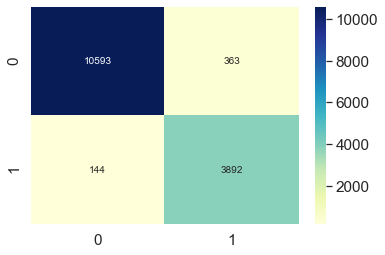

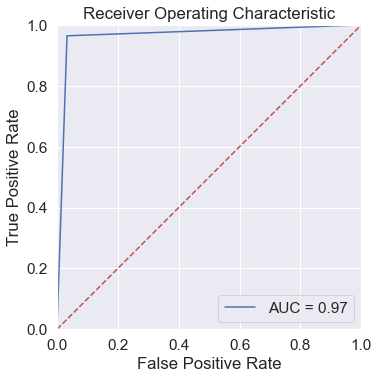

In [83]:
# predicting the test data
Y_svm = model.predict(X_test_tfidf)
print(metrics.classification_report(Y_test, Y_svm))
plot_confussion_matrix(Y_test, Y_svm)
plot_roc_curve(Y_test, Y_svm)

### a.2.1: TFIDF-LSTM

In [84]:
def prepare_lstm_tfidf(x):
    header_tfidf = tfidf.transform(x['Headline'].values.astype('U'))
    body_tfidf = tfidf.transform(x['articleBody'].values.astype('U'))
    header_tfidf = header_tfidf.toarray()
    body_tfidf = body_tfidf.toarray()
    output = np.stack((header_tfidf, body_tfidf), axis=1)
    return output

In [85]:
X_tf_ls_train = prepare_lstm_tfidf(X_train)
X_tf_ls_val = prepare_lstm_tfidf(X_val)
X_tf_ls_test = prepare_lstm_tfidf(X_test)

In [86]:
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

In [87]:
# input now transformed into 3-d array
X_tf_ls_train.shape

(15048, 2, 500)

In [88]:
Y_train.shape

(15048,)

Epoch 1/4
7524/7524 [==============================] - 87s 12ms/step - loss: 0.5902 - accuracy: 0.6335 - val_loss: 0.5048 - val_accuracy: 0.7041
Epoch 2/4
7524/7524 [==============================] - 87s 12ms/step - loss: 0.4773 - accuracy: 0.7099 - val_loss: 0.5043 - val_accuracy: 0.6599
Epoch 3/4
7524/7524 [==============================] - 87s 12ms/step - loss: 0.4280 - accuracy: 0.7443 - val_loss: 0.4401 - val_accuracy: 0.7254
Epoch 4/4
7524/7524 [==============================] - 88s 12ms/step - loss: 0.4004 - accuracy: 0.7575 - val_loss: 0.4127 - val_accuracy: 0.7575


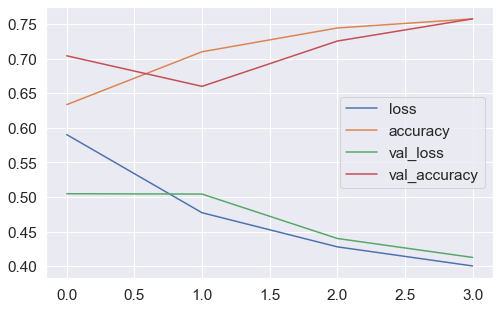

In [98]:
# creating an lstm model on Keras without the embedding layer
# the model bypass the embedding layer and take input directly from the tfidf vecter
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model2 = keras.models.Sequential()
model2.add(keras.layers.LSTM(500,
                            input_shape=(None, 500),
                            return_sequences=True))
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(1, activation='sigmoid'))
model2.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])
model2.fit(X_tf_ls_train, Y_train, 
           validation_data=(X_tf_ls_val, Y_val),
           epochs=4, batch_size=2, verbose=1)

In [99]:
# predicting the test data
Y_lstm = model2.predict(X_tf_ls_test)

In [100]:
Y_lstm = Y_lstm.mean(axis=1)
Y_lstm = np.rint(Y_lstm)

              precision    recall  f1-score   support

           0      0.963     0.951     0.957     10956
           1      0.872     0.900     0.886      4036

    accuracy                          0.938     14992
   macro avg      0.918     0.926     0.922     14992
weighted avg      0.938     0.938     0.938     14992



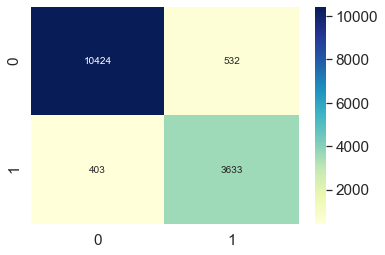

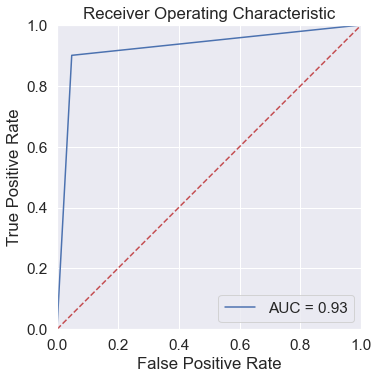

In [101]:
# model results
print(metrics.classification_report(Y_test, Y_lstm.reshape(len(Y_lstm)), digits=3))
plot_confussion_matrix(Y_test, Y_lstm.reshape(len(Y_lstm)))
plot_roc_curve(Y_test, Y_lstm.reshape(len(Y_lstm)))

### a.1.2: Bert-SVM

In [102]:
# importing pretrained bert from 'bert-base-uncased'
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset,DataLoader
bert = BertModel.from_pretrained('distilbert-base-uncased',
           output_hidden_states = True,)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.3.attention.v_lin.weight', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.4.sa_layer_norm.bias', 'distilbert.transformer.layer.5.sa_layer_norm.bias', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'vocab_projector.weight', 'distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.transformer.layer.2.output_layer_norm.weight', 'distilbert.transformer.layer.1.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.sa_layer

In [103]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [104]:
def prepare_embedding(text):
    indexed_tokens_list = []
    segments_ids_list = []
    max_length = 512
    for i in text:
        indexed_tokens = tokenizer.encode(i, max_length=512)
        padding_length = max_length - len(indexed_tokens)
        indexed_tokens = indexed_tokens + [0]*padding_length
        segments_ids = [1]*len(indexed_tokens)
        indexed_tokens_list.append(indexed_tokens)
        segments_ids_list.append(segments_ids)
    tokens_tensor = torch.tensor(indexed_tokens_list)
    segments_tensors = torch.tensor(segments_ids_list)
    return tokens_tensor, segments_tensors

In [105]:
def get_embedding(tokens_tensor, segments_tensors):
    dataset = TensorDataset(tokens_tensor,segments_tensors)
    dataloader = DataLoader(dataset,batch_size=1,shuffle=False)
    max_pool_embedding = []
    with torch.no_grad():
        for tokens_tensor,segments_tensors in dataloader:
            outputs = bert(tokens_tensor, segments_tensors)
            hidden_states = outputs[2][1:]
            token_embeddings = hidden_states[-1]
            token_embeddings = torch.squeeze(token_embeddings, dim=0)
            list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]
            max_pool = list_token_embeddings[0]
            max_pool_embedding.append(max_pool)
    return max_pool_embedding

In [109]:
headline = X_train['Headline'][:10000].values

In [110]:
body = X_train['articleBody'][:10000].values

In [111]:
tokens_tensor_headline, segments_tensors_headline = prepare_embedding(headline)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [112]:
tokens_tensor_body, segments_tensors_body = prepare_embedding(body)

In [123]:
headline_embedding = get_embedding(tokens_tensor_headline, segments_tensors_headline)

In [124]:
body_embedding = get_embedding(tokens_tensor_body, segments_tensors_body)

In [139]:
headline_embedding = np.array(headline_embedding)

In [140]:
body_embedding = np.array(body_embedding)

In [143]:
X_be_sv = np.concatenate((headline_embedding, body_embedding), axis=1)

In [144]:
X_be_sv.shape

(10000, 1536)

In [146]:
X_be_sv_train = X_be_sv[:9000]
X_be_sv_test = X_be_sv[9000:10000]

In [147]:
Y_be_sv_train = Y_train[:9000]
Y_be_sv_test = Y_train[9000:10000]

In [155]:
# Building the SVM model
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto']}
model3 = GridSearchCV(SVC(kernel='rbf'), parameters, cv=3, n_jobs=-1)
model3.fit(X_be_sv_train, Y_be_sv_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1.0, 10], 'gamma': [1, 'auto']})

In [156]:
model3 = model3.best_estimator_

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       479
           1       0.78      0.70      0.74       521

    accuracy                           0.74      1000
   macro avg       0.75      0.75      0.74      1000
weighted avg       0.75      0.74      0.74      1000



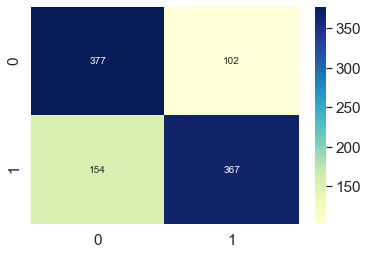

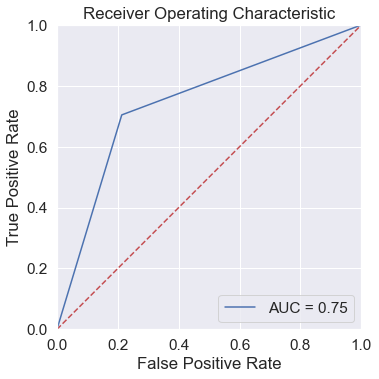

In [157]:
# predicting the test data
Y_svm = model3.predict(X_be_sv_test)
print(metrics.classification_report(Y_be_sv_test, Y_svm))
plot_confussion_matrix(Y_be_sv_test, Y_svm)
plot_roc_curve(Y_be_sv_test, Y_svm)

### a.2.2: Bert-LSTM

In [159]:
X_be_ls = np.stack((headline_embedding, body_embedding), axis=1)

In [160]:
X_be_ls_train = X_be_ls[:9000]
X_be_ls_test = X_be_ls[9000:10000]

In [162]:
Y_be_ls_train = Y_be_sv_train
Y_be_ls_test = Y_be_sv_test

In [173]:
# building bert sltm model
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model4 = keras.models.Sequential()
model4.add(keras.layers.LSTM(768,
                            input_shape=(None, 768),
                            return_sequences=True))
model4.add(keras.layers.Dropout(0.4))
model4.add(keras.layers.Dense(1, activation='sigmoid'))
model4.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])
model4.fit(X_be_ls_test, Y_be_ls_test, 
           validation_data=(X_be_ls_test, Y_be_ls_test),
           epochs=5, batch_size=2, verbose=1)

Epoch 1/5
500/500 [==============================] - 14s 28ms/step - loss: 0.7611 - accuracy: 0.4860 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
500/500 [==============================] - 14s 28ms/step - loss: 0.7260 - accuracy: 0.5205 - val_loss: 0.6924 - val_accuracy: 0.5210
Epoch 3/5
500/500 [==============================] - 14s 28ms/step - loss: 0.7214 - accuracy: 0.5100 - val_loss: 0.6925 - val_accuracy: 0.5210
Epoch 4/5
500/500 [==============================] - 14s 28ms/step - loss: 0.7150 - accuracy: 0.5065 - val_loss: 0.6923 - val_accuracy: 0.5210
Epoch 5/5
500/500 [==============================] - 14s 28ms/step - loss: 0.7198 - accuracy: 0.4990 - val_loss: 0.7052 - val_accuracy: 0.5210


In [209]:
# predicting the test data
Y_lstm = model4.predict(X_be_ls_test)
Y_lstm = Y_lstm.mean(axis=1)
Y_lstm = np.rint(Y_lstm)

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       479
           1      0.521     1.000     0.685       521

    accuracy                          0.521      1000
   macro avg      0.261     0.500     0.343      1000
weighted avg      0.271     0.521     0.357      1000



C:\Users\Ice\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ice\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ice\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


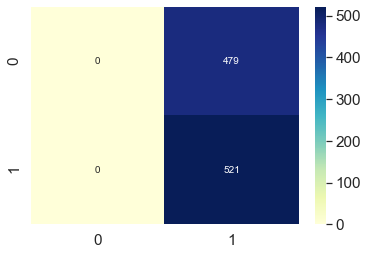

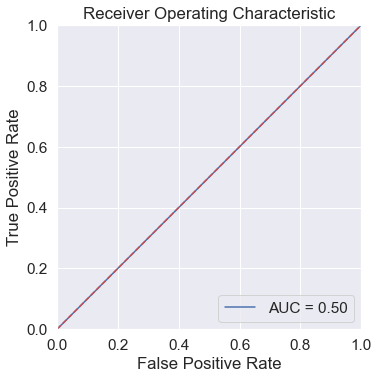

In [176]:
# model results
print(metrics.classification_report(Y_be_ls_test, Y_lstm, digits=3))
plot_confussion_matrix(Y_be_ls_test, Y_lstm)
plot_roc_curve(Y_be_ls_test, Y_lstm)

### Task 2 preparation

In [177]:
# defining a fuction to prepare data for multiclass classification
def prepare_stance(data):
    df = data
    related = {'agree': 1,
               'discuss': 2,
               'disagree': 3,
               'unrelated': 0}
    df['Stance'] = df['Stance'].replace(related)
    df = df.drop(df[df['Stance']==0].index)
    y = df[['Stance']]
    x = df[['Headline', 'articleBody']]
    return x, y

In [178]:
X_train, Y_train = prepare_stance(train)
X_val, Y_val = prepare_stance(val)
X_test, Y_test = prepare_stance(test)

In [179]:
# data cleaning
X_train = clean_data(X_train)
X_val = clean_data(X_val)
X_test = clean_data(X_test)

In [180]:
# resampling the train data using random under samplier
X_train, Y_train = rus.fit_resample(X_train, Y_train)
temp_df = X_train
temp_df['Stance'] = Y_train
temp_df = temp_df.sample(frac=1, random_state=seed)
X_train = temp_df.drop(['Stance'], axis=1)
Y_train = temp_df['Stance']

In [181]:
Y_val = Y_val['Stance']
Y_test = Y_test['Stance']

1    474
2    474
3    474
Name: Stance, dtype: int64

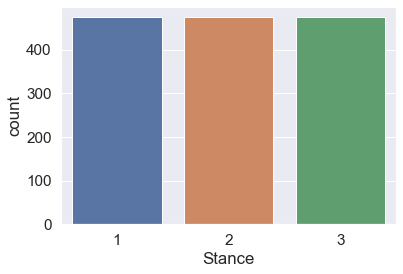

In [182]:
# ploting out classes in the train data
sn.countplot(x=Y_train)
Y_train.value_counts()

In [183]:
# implimenting one-hot encoding on the classes
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_test = pd.get_dummies(Y_test)

In [184]:
# creating tfidf vectors
X_tf_ls_train = prepare_lstm_tfidf(X_train)
X_tf_ls_val = prepare_lstm_tfidf(X_val)
X_tf_ls_test = prepare_lstm_tfidf(X_test)

### b: TDIF-LSTM

In [192]:
# matching y dimension with model output
Y_tf_ls_train = np.stack((Y_train.values, Y_train.values), axis=1)
Y_tf_ls_val = np.stack((Y_val.values, Y_val.values), axis=1)
Y_tf_ls_test = np.stack((Y_test.values, Y_test.values), axis=1)

In [193]:
Y_tf_ls_train.shape

(1422, 2, 3)

In [194]:
X_tf_ls_train.shape

(1422, 2, 500)

In [197]:
# building multiclass LSTM model
keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model5 = keras.models.Sequential()
model5.add(keras.layers.LSTM(500,
                            input_shape=(None, 500),
                            return_sequences=True))
model5.add(keras.layers.Dropout(0.2))
model5.add(keras.layers.Dense(3, activation='softmax'))
model5.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics = ['accuracy'])
model5.fit(X_tf_ls_train, Y_tf_ls_train, 
           validation_data=(X_tf_ls_val, Y_tf_ls_val),
           epochs=6, batch_size=2, verbose=1)

Epoch 1/6
711/711 [==============================] - 10s 13ms/step - loss: 0.9155 - accuracy: 0.5942 - val_loss: 0.7928 - val_accuracy: 0.6725
Epoch 2/6
711/711 [==============================] - 9s 13ms/step - loss: 0.7094 - accuracy: 0.7004 - val_loss: 0.8750 - val_accuracy: 0.6229
Epoch 3/6
711/711 [==============================] - 9s 13ms/step - loss: 0.6161 - accuracy: 0.7409 - val_loss: 0.8104 - val_accuracy: 0.6551
Epoch 4/6
711/711 [==============================] - 9s 13ms/step - loss: 0.5662 - accuracy: 0.7595 - val_loss: 0.9303 - val_accuracy: 0.6320
Epoch 5/6
711/711 [==============================] - 9s 13ms/step - loss: 0.5237 - accuracy: 0.7831 - val_loss: 0.8420 - val_accuracy: 0.6709
Epoch 6/6
711/711 [==============================] - 9s 13ms/step - loss: 0.4994 - accuracy: 0.7873 - val_loss: 0.8446 - val_accuracy: 0.6837


In [219]:
# predicting test data
Y_lstm = model5.predict_classes(X_tf_ls_test)
Y_lstm = Y_lstm.mean(axis=1)
Y_lstm = np.rint(Y_lstm) +1

In [221]:
# creating a comaprer for the predicted data
Y_true = test.drop(test[test['Stance']==0].index)
Y_true = Y_true['Stance']
Y_true = np.array(Y_true)

              precision    recall  f1-score   support

           1      0.514     0.572     0.542      1113
           2      0.845     0.634     0.724      2686
           3      0.201     0.662     0.308       237

    accuracy                          0.619      4036
   macro avg      0.520     0.623     0.525      4036
weighted avg      0.716     0.619     0.650      4036



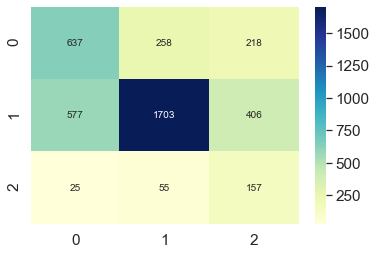

In [222]:
print(metrics.classification_report(Y_true, Y_lstm, digits=3))
plot_confussion_matrix(Y_true, Y_lstm)

### c: Finalised model

In [290]:
# creating a compy of test data
df_fn = test

In [291]:
# replacing text clasification with numbers
relation = {'agree': 1,
           'discuss': 2,
           'disagree': 3,
           'unrelated': 0}
df_fn['Stance'] = df_fn['Stance'].replace(relation)

In [292]:
# preparing x input for LSTM model
X = df_fn[['Headline', 'articleBody']]
X = clean_data(X)
X_tfidf = prepare_lstm_tfidf(X)

<ipython-input-14-7044a453f4ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Headline'] = [clean_text(i) for i in data['Headline']]
<ipython-input-14-7044a453f4ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['articleBody'] = [clean_text(i) for i in data['articleBody']]


In [293]:
# using the model previously trained on part a.2.1 to make a binary prediction
Y_pred = model2.predict(X_tfidf)
Y_pred = Y_pred.mean(axis=1)
Y_pred = np.rint(Y_pred)

In [294]:
# appending the result the test dataframe
df_fn['prediction'] = Y_pred
df_fn = df_fn.sort_values(by='prediction')
df_fn

,Headline,Body ID,Stance,articleBody,prediction
38740,Militant Group Says It Killed American Journal...,2261,0,From the midweek edition of the Morning Jolt:\...,0.0
3100,"Thanks Uncle Sam, we have your weapons airdrop...",816,0,A previously unverified audio recording that a...,0.0
4774,ISIS Reportedly Beheads U.S. Journalist James ...,1720,0,A South American nun suddenly started experien...,0.0
6172,"Oh Hey, Paul Rudd Was One Of The Dallas Airpor...",1212,0,Tiger Woods divorced Swedish model Elin Nordeg...,0.0
34662,Cloistered nun has a stomach ache hospital gi...,359,0,There has long been speculation about the myth...,0.0
...,...,...,...,...,...
41924,"Boko Haram Could Release Kidnapped Girls, Nige...",1430,2,Nigerian officials Friday announced they had a...,1.0
30909,Isis Syria News: Iraqi Pilots 'Training Isis F...,1606,2,(Reuters) - Iraqi pilots who have joined Islam...,1.0
49380,Mexico Says Missing Students Not Found In Firs...,1156,1,The bodies found in a mass grave were confirme...,1.0
48302,Hoax Busted: Report on Popular 'Dog Whisperer'...,1929,1,A report claiming that popular 'dog whisperer'...,1.0


In [295]:
# spliting the data by prediction result
df_fn_related = df_fn.loc[df_fn['prediction']==1]
df_fn_unrelated = df_fn.loc[df_fn['prediction']==0]

In [296]:
# taking the related prediction result from the fisrt model to prepare an imput for the second model
X = df_fn_related[['Headline', 'articleBody']]
X = clean_data(X)
X_tfidf = prepare_lstm_tfidf(X)

<ipython-input-14-7044a453f4ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Headline'] = [clean_text(i) for i in data['Headline']]
<ipython-input-14-7044a453f4ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['articleBody'] = [clean_text(i) for i in data['articleBody']]


In [297]:
# making sentiment prediction using the model from part b
Y_pred = model5.predict_classes(X_tfidf)

In [298]:
# preparing the model output for evaluation
Y_pred = Y_pred.mean(axis=1)
Y_pred = np.rint(Y_pred) +1

In [299]:
df_fn_related['prediction'] = Y_pred

<ipython-input-299-9021792870d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fn_related['prediction'] = Y_pred


In [300]:
df_fn = pd.concat([df_fn_unrelated, df_fn_related], axis=0)
df_fn

,Headline,Body ID,Stance,articleBody,prediction
38740,Militant Group Says It Killed American Journal...,2261,0,From the midweek edition of the Morning Jolt:\...,0.0
3100,"Thanks Uncle Sam, we have your weapons airdrop...",816,0,A previously unverified audio recording that a...,0.0
4774,ISIS Reportedly Beheads U.S. Journalist James ...,1720,0,A South American nun suddenly started experien...,0.0
6172,"Oh Hey, Paul Rudd Was One Of The Dallas Airpor...",1212,0,Tiger Woods divorced Swedish model Elin Nordeg...,0.0
34662,Cloistered nun has a stomach ache hospital gi...,359,0,There has long been speculation about the myth...,0.0
...,...,...,...,...,...
41924,"Boko Haram Could Release Kidnapped Girls, Nige...",1430,2,Nigerian officials Friday announced they had a...,2.0
30909,Isis Syria News: Iraqi Pilots 'Training Isis F...,1606,2,(Reuters) - Iraqi pilots who have joined Islam...,2.0
49380,Mexico Says Missing Students Not Found In Firs...,1156,1,The bodies found in a mass grave were confirme...,3.0
48302,Hoax Busted: Report on Popular 'Dog Whisperer'...,1929,1,A report claiming that popular 'dog whisperer'...,1.0


In [301]:
Y_true = df_fn['Stance']
Y_pred_all = df_fn['prediction']

              precision    recall  f1-score   support

           0      0.963     0.951     0.957     10956
           1      0.411     0.493     0.448      1113
           2      0.766     0.579     0.659      2686
           3      0.185     0.624     0.285       237

    accuracy                          0.845     14992
   macro avg      0.581     0.662     0.587     14992
weighted avg      0.874     0.845     0.855     14992



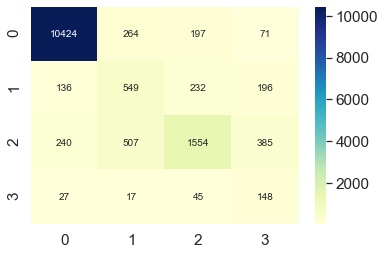

In [302]:
# final model results
print(metrics.classification_report(Y_true, Y_pred_all, digits=3))
plot_confussion_matrix(Y_true, Y_pred_all)